#### Absolute perm simulation

https://notebook.community/PMEAL/OpenPNM/examples/simulations/Berea%20Sandstone%20-%20Effective%20Permeability

#### Invasion percolation

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/632 [00:00<?, ?it/s]

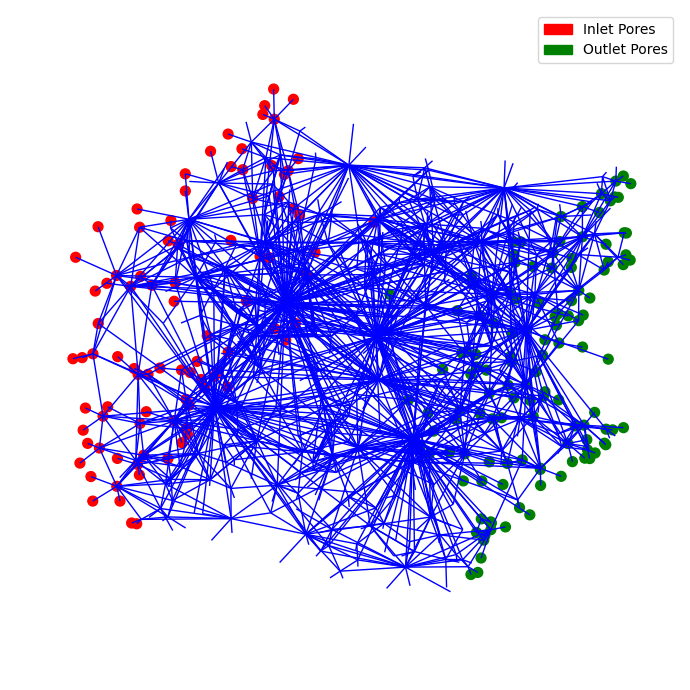

In [11]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import random
import warnings
from skimage.measure import euler_number

warnings.filterwarnings('ignore')

np.random.seed(0)
im = np.load('fake.npy')
resolution = 2.32e-06
snow = ps.networks.snow2(
    phases=im,
    phase_alias={True:"void",False:"solid"},
    voxel_size=resolution)

ws = op.Workspace()
pn = op.io.network_from_porespy(snow.network)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
proj = pn.project

# add boundary pores
min_coor = pn['pore.coords'].min()
max_coor = pn['pore.coords'].max()

def marker_arr(min_value,max_value,boundary='left'):

    if boundary == 'left':
        marker = [
                min_value,
                random.uniform(min_value,max_value),
                random.uniform(min_value,max_value)
                ]

    if boundary == "right":
        marker = [
        max_value,
        random.uniform(min_value,max_value),
        random.uniform(min_value,max_value)
        ]
    
    return marker


left_marker = [marker_arr(min_coor,max_coor) for _ in range(20)]
right_marker = [marker_arr(min_coor,max_coor,'right') for _ in range(20)]
left_marker = np.array(left_marker)
right_marker = np.array(right_marker)

op.topotools.find_surface_pores(network=pn, markers=left_marker, label='left')
op.topotools.find_surface_pores(network=pn, markers=right_marker, label='right')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Inlet Pores')
green_patch = mpatches.Patch(color='green', label='Outlet Pores')

fig, ax = plt.subplots(figsize=(7, 7))
op.visualization.plot_connections(network=pn, ax=ax)
op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), 
                                    markersize=50, ax=ax, c='r')
op.visualization.plot_coordinates(network=pn, pores=pn.pores('right'), 
                                    markersize=50, ax=ax, c='g')
plt.axis('off')
plt.legend(handles=[red_patch,green_patch])


# %% Invasion Percolation
air = op.phase.Air(network=pn,name='air')
air['pore.surface_tension'] = 0.072
air['pore.contact_angle'] = 180.0
air.add_model_collection(op.models.collections.phase.air)
air.add_model_collection(op.models.collections.physics.basic)
air.regenerate_models()
water = op.phase.Water(network=pn,name='water')
water.add_model_collection(op.models.collections.phase.water)
water.add_model_collection(op.models.collections.physics.basic)
water.regenerate_models()

ip = op.algorithms.InvasionPercolation(network=pn, phase=air)
Finlets_init = pn.pores('left')
Finlets=([Finlets_init[x] for x in range(0, len(Finlets_init), 2)])
ip.set_inlet_BC(pores=Finlets)
ip.run()

In [22]:
def sat_occ_update(network, nwp, wp, ip, i):
    pore_mask = ip['pore.invasion_sequence'] < i
    throat_mask = ip['throat.invasion_sequence'] < i
    sat_p = np.sum(network['pore.volume'][pore_mask])
    sat_t = np.sum(network['throat.volume'][throat_mask])
    sat1 = sat_p + sat_t
    bulk = network['pore.volume'].sum() + network['throat.volume'].sum()
    sat = sat1/bulk
    nwp['pore.occupancy'] = pore_mask
    nwp['throat.occupancy'] = throat_mask
    wp['throat.occupancy'] = 1-throat_mask
    wp['pore.occupancy'] = 1-pore_mask
    return sat

def Rate_calc(network, phase, inlet, outlet, conductance):
    phase.regenerate_models()
    St_p = op.algorithms.StokesFlow(network=network, phase=phase)
    St_p.settings._update({'conductance' : conductance})
    St_p.set_value_BC(pores=inlet, values=1)
    St_p.set_value_BC(pores=outlet, values=0)
    St_p.run()
    val = np.abs(St_p.rate(pores=inlet, mode='group'))
    return val

flow_in = pn.pores('left')
flow_out = pn.pores('right')
model_mp_cond = op.models.physics.multiphase.conduit_conductance
air.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')
water.add_model(model=model_mp_cond, propname='throat.conduit_hydraulic_conductance',
              throat_conductance='throat.hydraulic_conductance', mode='medium', regen_mode='deferred')

flow_in = pn.pores('left')
flow_out = pn.pores('right')
max_seq = np.max([np.max(ip['pore.invasion_sequence']),
          np.max(ip['throat.invasion_sequence'])])

#### Calculate the rate of flow

In [36]:
air.regenerate_models()
water.regenerate_models()
sat = sat_occ_update(network=pn, nwp=air, wp=water, ip=ip, i=1)
Rate_abs_nwp = Rate_calc(pn, air, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')
Rate_abs_wp = Rate_calc(pn, water, flow_in, flow_out, conductance = 'throat.hydraulic_conductance')

In [37]:
image_size = 128
resolution = 2.32e-06
L = image_size*resolution
A = (image_size*resolution)**2
mu = water['pore.viscosity'].max()
kabs = (Rate_abs_wp*L*mu)/(A)
kabs = kabs/0.98e-12*1000

In [38]:
print(f'absolute permeability is {kabs} md')

absolute permeability is [865.01711363] md


In [30]:
mu

0.000893190947459112

In [39]:
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)

------------------------------------------------------------
  - WARNING: Attempting to estimate inlet area...will be low 
  - SOURCE : openpnm.topotools._topotools.get_domain_area 
  - TIME   : 2022-12-15 17:16:15,415    
------------------------------------------------------------
------------------------------------------------------------
  - ERROR  : Detected inlet pores are not coplanar 
  - SOURCE : openpnm.topotools._topotools.get_domain_area 
  - TIME   : 2022-12-15 17:16:15,419    
------------------------------------------------------------
------------------------------------------------------------
  - ERROR  : Detected outlet pores are not coplanar 
  - SOURCE : openpnm.topotools._topotools.get_domain_area 
  - TIME   : 2022-12-15 17:16:15,421    
------------------------------------------------------------
------------------------------------------------------------
  - WARNING: Detected inlets are not oriented along a principle axis 
  - SOURCE : openpnm.topotools._topo

In [43]:
L

0.00013146809624757256

In [41]:
A = (image_size*resolution)**2


In [42]:
A

8.818524159999999e-08

In [45]:
import numpy as np
import openpnm as op
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

pn = op.network.Cubic(shape=[15, 15, 15], spacing=1e-6)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()

phase = op.phase.Phase(network=pn)
phase['pore.viscosity']=1.0
phase.add_model_collection(op.models.collections.physics.basic)
phase.regenerate_models()

inlet = pn.pores('left')
outlet = pn.pores('right')
flow = op.algorithms.StokesFlow(network=pn, phase=phase)
flow.set_value_BC(pores=inlet, values=1)
flow.set_value_BC(pores=outlet, values=0)
flow.run()
phase.update(flow.soln)

Q = flow.rate(pores=inlet, mode='group')[0]
A = op.topotools.get_domain_area(pn, inlets=inlet, outlets=outlet)
L = op.topotools.get_domain_length(pn, inlets=inlet, outlets=outlet)
# K = Q * L * mu / (A * Delta_P) # mu and Delta_P were assumed to be 1.
K = Q * L / A
print(f'The value of K is: {K/0.98e-12*1000:.2f} mD')

------------------------------------------------------------
  - WARNING: Attempting to estimate inlet area...will be low 
  - SOURCE : openpnm.topotools._topotools.get_domain_area 
  - TIME   : 2022-12-15 17:18:38,902    
------------------------------------------------------------
------------------------------------------------------------
  - WARNING: Attempting to estimate domain length...could be
             low if boundary pores were not added 
  - SOURCE : openpnm.topotools._topotools.get_domain_length 
  - TIME   : 2022-12-15 17:18:38,904    
------------------------------------------------------------


The value of K is: 0.07 mD


In [17]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import random
import warnings
from skimage.measure import euler_number

warnings.filterwarnings('ignore')

np.random.seed(0)
im = np.load('1.npy')

snow = ps.networks.snow2(
    phases=im,
    phase_alias={True:"void",False:"solid"},
    voxel_size=2.32e-06)

ws = op.Workspace()
pn = op.io.network_from_porespy(snow.network)
pn.add_model_collection(op.models.collections.geometry.spheres_and_cylinders)
pn.regenerate_models()
proj = pn.project

# add boundary pores
min_coor = pn['pore.coords'].min()
max_coor = pn['pore.coords'].max()

def marker_arr(min_value,max_value,boundary='left'):

    if boundary == 'left':
        marker = [
                min_value,
                random.uniform(min_value,max_value),
                random.uniform(min_value,max_value)
                ]

    if boundary == "right":
        marker = [
        max_value,
        random.uniform(min_value,max_value),
        random.uniform(min_value,max_value)
        ]
    
    return marker


left_marker = [marker_arr(min_coor,max_coor) for _ in range(20)]
right_marker = [marker_arr(min_coor,max_coor,'right') for _ in range(20)]
left_marker = np.array(left_marker)
right_marker = np.array(right_marker)

op.topotools.find_surface_pores(network=pn, markers=left_marker, label='left')
op.topotools.find_surface_pores(network=pn, markers=right_marker, label='right')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/764 [00:00<?, ?it/s]

In [18]:
phase = op.phase.Phase(network=pn)
phase['pore.viscosity']=1.0
phase.add_model_collection(op.models.collections.physics.basic)
phase.regenerate_models()

inlet = pn.pores('left')
outlet = pn.pores('right')
flow = op.algorithms.StokesFlow(network=pn, phase=phase)
flow.set_value_BC(pores=inlet, values=1000)
flow.set_value_BC(pores=outlet, values=0)
flow.run()
phase.update(flow.soln)

In [19]:
Q = flow.rate(pores=inlet, mode='group')[0]
A = (128*resolution)**2
L = resolution*128
# K = Q * L * mu / (A * Delta_P) # mu and Delta_P were assumed to be 1.
K = Q * L / (A*1000)
print(f'The value of K is: {K/0.98e-12*1000:.2f} mD')

The value of K is: 105.29 mD


In [5]:
resolution = 2.32e-06


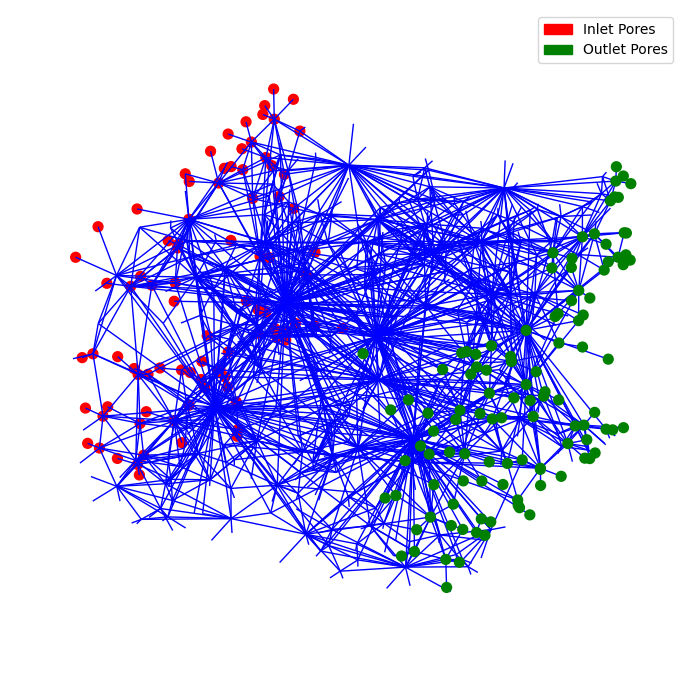

In [10]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Inlet Pores')
green_patch = mpatches.Patch(color='green', label='Outlet Pores')

fig, ax = plt.subplots(figsize=(7, 7))
op.visualization.plot_connections(network=pn, ax=ax)
op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), 
                                    markersize=50, ax=ax, c='r')
op.visualization.plot_coordinates(network=pn, pores=pn.pores('right'), 
                                    markersize=50, ax=ax, c='g')
plt.axis('off')
plt.legend(handles=[red_patch,green_patch])

In [24]:
im1 = np.load('1.npy')
im2 = np.load('fake.npy')
from skimage.measure import euler_number


In [26]:
euler_number(im2,connectivity=3)

8

In [28]:
convert = 9.869233e-16*600

In [29]:
convert

5.921539800000001e-13